# Model overview

In [14]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from data.make_dataset import clean_application_data, add_ratio_features
from features.make_features import load_feature_config
from util.util import transform_omit_model

## Loading data

In [2]:
df = pd.read_csv('../data/raw/application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
config = load_feature_config("../src/config.yaml")
target = config["target"]
num_features = config["numeric_features"]
cat_features = config["categorical_features"]

feature_list = num_features + cat_features

In [7]:
df = clean_application_data(df)
df = add_ratio_features(df)

X = df[feature_list]
y = df[target]

In [5]:
pipeline = joblib.load("../artifacts/logreg_pipeline.pkl")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Gain Chart

In [23]:
def build_gain_chart(y_true, y_pred, n_buckets=10):
    df_gain = pd.DataFrame({
        "y_true": y_true,
        "pd": y_pred
    })
    df_gain = df_gain.sort_values("pd", ascending=False).reset_index(drop=True)

    df_gain["bucket"] = pd.qcut(
        df_gain.index, 
        q=n_buckets, 
        labels=False
    ) + 1

    bucket_stats = df_gain.groupby("bucket").agg(
        total=("y_true", "count"),
        bads=("y_true", "sum"),
        avg_pd=("pd", "mean")
    ).reset_index()

    bucket_stats["bad_rate"] = bucket_stats["bads"] / bucket_stats["total"]

    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.bar(
        bucket_stats["bucket"], 
        bucket_stats["bad_rate"], 
        color="skyblue", 
        alpha=0.7, 
        label="Bad Rate"
    )
    ax1.set_xlabel("Bucket")
    ax1.set_ylabel("Bad Rate")
    ax1.set_ylim(0, bucket_stats["bad_rate"].max()*1.2)

    ax2 = ax1.twinx()
    ax2.plot(
        bucket_stats["bucket"], 
        bucket_stats["avg_pd"], 
        color="red", 
        marker="o", 
        label="PD"
    )
    ax2.set_ylabel("PD")
    ax2.set_ylim(0, bucket_stats["avg_pd"].max()*1.2)

    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.title("Gain Chart")
    plt.show()

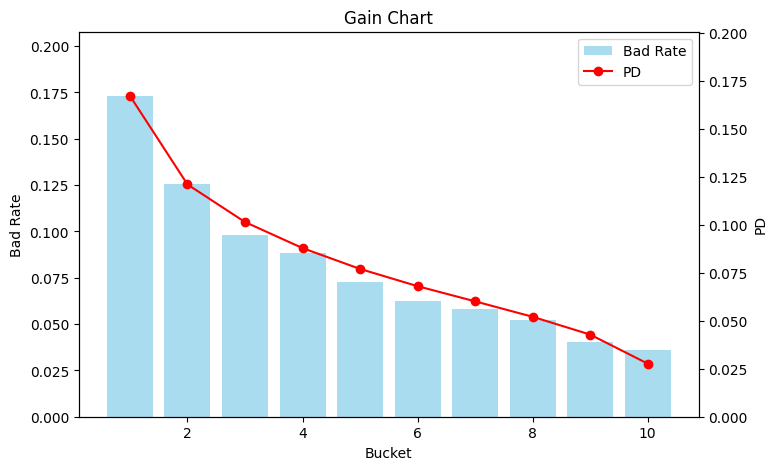

In [24]:
build_gain_chart(
    y_test,
    pipeline.predict_proba(X_test)[:, 1]
)